## **Data Loading & Libraries**

In [52]:
import pandas as pd
import numpy as np
from random import *
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings

# Suppress warnings for cleaner notebook outputs
warnings.filterwarnings("ignore")

In [53]:
# Load the cleaned dataset
salaries = pd.read_csv("./clean_kaggle_data_2022.csv", low_memory = False, encoding = 'latin2')
salaries.shape

(8137, 298)

## **Data Cleaning & Preprocessing**

- Dropping Q5 since there is only one type of *response* ('No')
- Dropping Q26 since there are date which are irrelevant to the question itself

In [54]:
print(salaries['Q5'].unique())
print(salaries['Q26'].unique())

['Are you currently a student? (high school, university, or graduate)'
 'No']
['Approximately how many individuals are responsible for data science workloads at your place of business?'
 '2-Jan' '20+' '4-Mar' '9-May' '0' '14-Oct' '15-19']


In [55]:
def CleanData(df):
    # Drop the first row (question details)
    if df.shape[0] > 8136:
      df.drop(df.index[0], inplace=True)

    # Drop irrelevant columns, adjust this list as needed based on analysis
    irrelevant_columns = ['Duration (in seconds)','Q5','Q7_1','Q7_2','Q7_3','Q7_4','Q7_5','Q7_6','Q7_7','Q13_1','Q13_2','Q13_3','Q13_4','Q13_5','Q13_6','Q13_7','Q13_8','Q13_9','Q13_10','Q13_11','Q13_12','Q13_13','Q13_14','Q26'] # Drop Q5 coz only no is the answer
    df.drop(columns=irrelevant_columns, inplace=True, errors='ignore')

    # Reset the index after dropping rows/columns
    df.reset_index(drop=True, inplace=True)

    # Convert columns to numeric where possible (for numerical analysis)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='ignore')

    return df

# Apply the function to clean the dataset
salaries = CleanData(salaries)
salaries.shape


(8136, 274)

Replacing rare-values in question Q23

In [56]:
salaries['Q23'].unique()

array(['Data Scientist', 'Software Engineer', 'Research Scientist',
       'Developer Advocate',
       'Data Analyst (Business, Marketing, Financial, Quantitative, etc)',
       'Data Engineer', 'Other', 'Machine Learning/ MLops Engineer',
       'Engineer (non-software)', 'Teacher / professor',
       'Manager (Program, Project, Operations, Executive-level, etc)',
       'Statistician', 'Data Administrator', 'Data Architect'],
      dtype=object)

## **Rare Value Replacement Function**

In [57]:
def replace_rare_values(df, column_name, threshold):

    # Count the occurrences of each unique value in the column
    value_counts = df[column_name].value_counts()

    # Identify values that appear less than the threshold
    rare_values = value_counts.index[value_counts < threshold]

    # Create a mask for rows containing these rare values and replace them with 'Other'
    df.loc[df[column_name].isin(rare_values), column_name] = "Other"

    return df

#salaries = replace_rare_values(salaries, 'Q8', 50)
#salaries = replace_rare_values(salaries, 'Q4', 50)
salaries = replace_rare_values(salaries, 'Q23', 50)

### **Impute missing values (single column responses)**

1. Identify columns with single column responses

2. Address missing values in those columns

In [58]:
def ImputingSingleColMissingValues(df):
    # Identify single-column names that need imputing, including the target column
    single_col_names = [col for col in df.columns if '_' not in col or col == 'Q29_Encoded']

    # Calculate missing value percentages for single-column responses
    missing_percentages = df[single_col_names].isnull().mean()

    # Drop columns with more than 30% missing values
    high_missing_cols = missing_percentages[missing_percentages > 0.3].index.tolist()
    df.drop(columns=high_missing_cols, inplace=True)
    print(f"Dropped {len(high_missing_cols)} columns with more than 30% missing values.")
    print(f"dropped {high_missing_cols}")

    # Recalculate single_col_names after dropping high-missing columns
    single_col_names = [col for col in df.columns if col in single_col_names]

    print("Percentage of null values before imputation:")
    print(df[single_col_names].isnull().sum() * 100 / len(df))

    # Address missing values in remaining single-column responses
    for col in single_col_names:
        if df[col].dtype == 'object':
            df[col].fillna("Unknown", inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

    print("Percentage of null values after imputation (should be zero):")
    print(df[single_col_names].isnull().sum() * 100 / len(df))
    assert df[single_col_names].isnull().values.sum() == 0, \
        "There are still missing values remaining!"

    return df

# Apply the function to clean the dataset
salaries = ImputingSingleColMissingValues(salaries)


Dropped 4 columns with more than 30% missing values.
dropped ['Q9', 'Q22', 'Q32', 'Q43']
Percentage of null values before imputation:
Q2             0.000000
Q3             0.000000
Q4             0.000000
Q8             0.000000
Q11            0.000000
Q16            8.407080
Q23            0.000000
Q24            0.000000
Q25            0.000000
Q27            0.000000
Q29            0.000000
Q30            0.614553
Q29_Encoded    0.000000
dtype: float64
Percentage of null values after imputation (should be zero):
Q2             0.0
Q3             0.0
Q4             0.0
Q8             0.0
Q11            0.0
Q16            0.0
Q23            0.0
Q24            0.0
Q25            0.0
Q27            0.0
Q29            0.0
Q30            0.0
Q29_Encoded    0.0
dtype: float64


### **Encode categorical features (sinlge column responses)**

The code below is to create a new feature based on the average tech salaries for each countries. As the encoding in this part will affect my features creation, I moved it from part 2 to here.

In [59]:
salary_mapping = {
    # Countries with average tech salaries above $100,000
    'United States of America': 10,
    'Switzerland': 10,
    'Australia': 9,
    'Israel': 9,
    'Denmark': 9,
    'Norway': 9,

    # Countries with average tech salaries between $80,000 and $100,000
    'Canada': 8,
    'United Kingdom': 8,
    'Germany': 8,
    'Netherlands': 8,
    'Sweden': 8,
    'Finland': 8,

    # Countries with average tech salaries between $60,000 and $80,000
    'France': 7,
    'Ireland': 7,
    'Belgium': 7,
    'Singapore': 7,
    'New Zealand': 7,

    # Countries with average tech salaries between $40,000 and $60,000
    'Japan': 6,
    'South Korea': 6,
    'Italy': 6,
    'Spain': 6,
    'Portugal': 6,

    # Countries with average tech salaries between $20,000 and $40,000
    'Brazil': 5,
    'Argentina': 5,
    'Chile': 5,
    'China': 5,
    'Malaysia': 5,
    'Russia': 5,
    'Turkey': 5,
    'South Africa': 5,
    'Romania': 5,
    'Mexico': 5,
    'Colombia': 5,
    'Iran': 5,

    # Countries with average tech salaries between $10,000 and $20,000
    'India': 4,
    'Indonesia': 4,
    'Philippines': 4,
    'Pakistan': 4,
    'Egypt': 4,
    'Nigeria': 4,
    'Vietnam': 4,
    'Bangladesh': 4,
    'Kenya': 4,
    'Ghana': 4,
    'Cameroon': 4,
    'Morocco': 4,
    'Sri Lanka': 4,
    'Ukraine': 4,
    'Algeria': 4,

    # Countries with average tech salaries below $10,000
    'Ethiopia': 3,
    'Zimbabwe': 3,
    'Nepal': 3,
    'Uganda': 3,

    # Special cases
    'Other': 2,
    'I do not wish to disclose my location': 2
}

# Assuming 'Q4' is the column with country names in the 'salaries' DataFrame
salaries['Country_Salary_Rank'] = salaries['Q4'].map(salary_mapping)

# Display the updated DataFrame with the new column
salaries[['Q4', 'Country_Salary_Rank']].head()


,Q4,Country_Salary_Rank
0,France,7.0
1,Germany,8.0
2,Australia,9.0
3,United States of America,10.0
4,United States of America,10.0


Sources:
https://smartdataweek.com/article/average-software-developer-salaries-salary-comparison-by-country

https://smartdataweek.com/article/average-software-engineering-salaries-by-country-in-2022

https://qubit-labs.com/average-software-developer-salaries-salary-comparison-country/

https://codesubmit.io/blog/software-engineer-salary-by-country/

Same as the above, The code is to create a new feature based on the average job salaries for each job title.

In [60]:
# Job salary mapping
job_salary_mapping = {
    'Data Scientist': 95,
    'Software Engineer': 90,
    'Research Scientist': 85,
    'Developer Advocate': 80,
    'Data Analyst': 75,
    'Data Engineer': 92,
    'Other': 70,
    'Machine Learning/MLops Engineer': 98,
    'Engineer (non-software)': 88,
    'Teacher / Professor': 70,
    'Manager': 100,
    'Statistician': 78,
    'Data Administrator': 72,
    'Data Architect': 96
}

# Map the job titles in 'Q23' to the rankings in job_salary_mapping
salaries['Job_Salary_Rank'] = salaries['Q23'].map(job_salary_mapping)

# Display the DataFrame to verify the new column
print(salaries['Job_Salary_Rank'].unique())


[95. 90. 85. 80. nan 92. 70. 88. 78. 72. 96.]


In [61]:
salaries['Job_Salary_Rank'].unique()

array([95., 90., 85., 80., nan, 92., 70., 88., 78., 72., 96.])

Sources:

https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/grossweeklyearningsbyoccupationearn06

https://www.bridgewateruk.com/2022/01/average-uk-salary-2022-by-profession/

https://www.totaljobs.com/salary-checker/salary-calculator



In [62]:
salaries.isnull().sum()

Q2                        0
Q3                        0
Q4                        0
Q6_1                   4374
Q6_2                   7018
                       ... 
Q44_12                 7820
Q29_Encoded               0
Q29_buckets               0
Country_Salary_Rank     670
Job_Salary_Rank        3351
Length: 272, dtype: int64

In [63]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the dataset (assuming `salaries` is already loaded)

# Process Q2 (Age Ranges)
age_means = {
    '18-21': 19.5, '22-24': 23, '25-29': 27, '30-34': 32, '35-39': 37,
    '40-44': 42, '45-49': 47, '50-54': 52, '55-59': 57, '60-69': 65, '70+': 75
}
salaries['Q2'] = salaries['Q2'].map(age_means)

# Process Q3 (Gender)
salaries['Q3'] = salaries['Q3'].apply(lambda x: x if x in ["Man", "Woman"] else "Unknown")
gender_mapping = {"Man": 0, "Woman": 1, "Unknown": 2}
salaries['Q3'] = salaries['Q3'].map(gender_mapping)


# Define income level mapping for Q4 (Country)
income_mapping = {
    # USA
    'United States of America': 'USA',
    # High-income countries
    'France': 'High Income', 'Germany': 'High Income', 'Australia': 'High Income',
    'Singapore': 'High Income', 'Italy': 'High Income', 'Japan': 'High Income', 'Canada': 'High Income',
    'Netherlands': 'High Income', 'South Korea': 'High Income',
    'United Kingdom of Great Britain and Northern Ireland': 'High Income',
    'Hong Kong (S.A.R.)': 'High Income', 'Belgium': 'High Income',
    'Israel': 'High Income', 'Ireland': 'High Income',
    'New Zealand': 'High Income', 'Switzerland': 'High Income',

    # Upper-middle-income countries
    'Brazil': 'Upper Middle Income', 'Argentina': 'Upper Middle Income',
    'Chile': 'Upper Middle Income', 'China': 'Upper Middle Income',
    'Malaysia': 'Upper Middle Income', 'Russia': 'Upper Middle Income',
    'Turkey': 'Upper Middle Income', 'South Africa': 'Upper Middle Income',
    'Romania': 'Upper Middle Income', 'Mexico': 'Upper Middle Income',
    'Colombia': 'Upper Middle Income', 'Iran, Islamic Republic of...': 'Upper Middle Income',

    # Lower-middle-income countries
    'India': 'Lower Middle Income', 'Indonesia': 'Lower Middle Income',
    'Philippines': 'Lower Middle Income', 'Pakistan': 'Lower Middle Income',
    'Egypt': 'Lower Middle Income', 'Nigeria': 'Lower Middle Income',
    'Vietnam': 'Lower Middle Income', 'Bangladesh': 'Lower Middle Income',
    'Kenya': 'Lower Middle Income', 'Ghana': 'Lower Middle Income',
    'Cameroon': 'Lower Middle Income', 'Morocco': 'Lower Middle Income',
    'Sri Lanka': 'Lower Middle Income', 'Ukraine': 'Lower Middle Income',
    'Algeria': 'Lower Middle Income',

    # Low-income countries
    'Ethiopia': 'Low Income', 'Zimbabwe': 'Low Income',
    'Nepal': 'Low Income', 'Uganda': 'Low Income',

    # Special cases
    'Other': 'Other',
    'I do not wish to disclose my location': 'Other'
}

salaries['Q4'] = salaries['Q4'].map(income_mapping)


#  Process Q8 (Education Level)
#education_mapping = {
#    'Some college/university study without earning a bachelor\x81E\x80\x81Es degree': 'Some College',
#    'Bachelor\x81E\x80\x81Es degree': "Bachelor's",
#    'Doctoral degree': "Doctorate",
#    'Master\x81E\x80\x81Es degree': "Master's",
#    'I prefer not to answer': 'Other',
#    'No formal education past high school': 'High School',
#    'Professional doctorate': 'Doctorate'
#}
#salaries['Q8'] = salaries['Q8'].map(education_mapping)
#education_order = {
#    'High School': 0, 'Some College': 1, "Bachelor's": 2,
#    "Master's": 3, 'Doctorate': 4, 'Other': 5
#}
#salaries['Q8'] = salaries['Q8'].map(education_order)

# Define years of education mapping based on common educational trajectories
education_years_mapping = {
    'No formal education past high school': 12,          # High School
    'Some college/university study without earning a bachelor\x81E\x80\x81Es degree': 14,  # Some College
    'Bachelor\x81E\x80\x81Es degree': 16,                # Bachelor's degree
    'Master\x81E\x80\x81Es degree': 18,                  # Master's degree
    'Doctoral degree': 22,                               # Doctorate (e.g., PhD)
    'Professional doctorate': 20,                        # Professional Doctorate (e.g., MD, JD)
    'I prefer not to answer': 0,                      # Treat as missing or unknown
    'Other': 0                                        # Treat as missing or unknown
}

# Apply the years of education mapping to Q8
salaries['Q8'] = salaries['Q8'].map(education_years_mapping)


# Process Q11 (Years of Coding Experience)
experience_mapping = {
    'For how many years have you been writing code and/or programming?': None,
    '10-20 years': 15, '20+ years': 25, '5-10 years': 7.5,
    '3-5 years': 4, '< 1 years': 0.5, '1-3 years': 2,
    'I have never written code': 0
}
salaries['Q11'] = salaries['Q11'].map(experience_mapping)
salaries.dropna(subset=['Q11'], inplace=True)

# Process Q16 (Machine Learning Experience)
ml_experience_mapping = {
    'Under 1 year': 0.5, '1-2 years': 1.5, '2-3 years': 2.5,
    '3-4 years': 3.5, '4-5 years': 4.5, '5-10 years': 7.5,
    '10-20 years': 15, 'I do not use machine learning methods': 0
}
salaries['Q16'] = salaries['Q16'].map(ml_experience_mapping)

from sklearn.preprocessing import LabelEncoder

# Process Q23 (Job Title) with Label Encoding


# Process Q24 (Industry) with Label Encoding
industry_mapping = {
    'Online Service/Internet-based Services': 'Technology',
    'Insurance/Risk Assessment': 'Finance',
    'Government/Public Service': 'Public Service',
    'Computers/Technology': 'Technology',
    'Accounting/Finance': 'Finance',
    'Academics/Education': 'Education',
    'Non-profit/Service': 'Service',
    'Medical/Pharmaceutical': 'Healthcare',
    'Marketing/CRM': 'Marketing',
    'Manufacturing/Fabrication': 'Manufacturing',
    'Energy/Mining': 'Energy',
    'Broadcasting/Communications': 'Communications',
    'Retail/Sales': 'Retail',
    'Shipping/Transportation': 'Transportation',
    'Other': 'Other'
}
salaries['Q24'] = salaries['Q24'].map(industry_mapping)


# Process Q25 (Company Size) with Ordinal Encoding
company_size_mapping = {
    '0-49 employees': 1, '50-249 employees': 2,
    '250-999 employees': 3, '1000-9,999 employees': 4,
    '10,000 or more employees': 5
}
salaries['Q25'] = salaries['Q25'].map(company_size_mapping)

# Process Q27 (ML Adoption Level) with Ordinal Encoding
ml_adoption_mapping = {
    'No (we do not use ML methods)': 0,
    'We are exploring ML methods (and may one day put a model into production)': 1,
    'We use ML methods for generating insights (but do not put working models into production)': 2,
    'We recently started using ML methods (i.e., models in production for less than 2 years)': 3,
    'We have well established ML methods (i.e., models in production for more than 2 years)': 4,
    'I do not know': -1  # Optional: treat as unknown
}
salaries['Q27'] = salaries['Q27'].map(ml_adoption_mapping)

# Process Q30 (Spending) with Midpoints
spending_mapping = {
    '$0 ($USD)': 0, '$1-$99': 50, '$100-$999': 550,
    '$1000-$9,999': 5500, '$10,000-$99,999': 55000,
    '$100,000 or more ($USD)': 100000
}
salaries['Q30'] = salaries['Q30'].map(spending_mapping)

# Display the final transformed dataset to verify
print(salaries[['Q2', 'Q3','Q4', 'Q8', 'Q11', 'Q16','Q23','Q24', 'Q25', 'Q27', 'Q30']].head())
print(salaries.filter(like='Industry').head())
print(salaries.filter(like='Job').head())


     Q2  Q3           Q4  Q8   Q11  Q16                 Q23             Q24  \
0  57.0   0  High Income  14  15.0  1.5      Data Scientist      Technology   
1  32.0   0  High Income  16  15.0  4.5   Software Engineer         Finance   
2  75.0   0  High Income  22  25.0  7.5  Research Scientist  Public Service   
3  42.0   0          USA  22  15.0  7.5  Developer Advocate      Technology   
4  42.0   0          USA  18  15.0  7.5      Data Scientist      Technology   

   Q25  Q27       Q30  
0    1    3    5500.0  
1    3    4       0.0  
2    4    3     550.0  
3    4    4     550.0  
4    4    4  100000.0  
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]
   Job_Salary_Rank
0             95.0
1             90.0
2             85.0
3             80.0
4             95.0


In [64]:
# Fill NaN values in Country_Salary_Rank with 0
salaries['Country_Salary_Rank'] = salaries['Country_Salary_Rank'].fillna(0)

# Fill NaN values in Job_Salary_Rank with 60
salaries['Job_Salary_Rank'] = salaries['Job_Salary_Rank'].fillna(60)

# Fill NaN values in Q4 with Other
salaries['Q4'] = salaries['Q4'].fillna('Other')

# Fill NaN values in Q16 with 0, indicating no machine learning experience
salaries['Q16'] = salaries['Q16'].fillna(0)

# Fill NaN values in Q30 with 0, indicating no spending if missing
salaries['Q30'] = salaries['Q30'].fillna(0)

# Verify that there are no more NaN values in the specified columns
assert salaries[['Q16', 'Q30']].isnull().sum().sum() == 0, "There are still missing values in Q16 or Q30!"

# Display unique values to confirm
for column in ['Q2', 'Q3', 'Q4', 'Q8', 'Q11', 'Q16', 'Q23', 'Q24', 'Q25', 'Q27', 'Q30','Country_Salary_Rank']:
    print(f"Unique values in {column}: {salaries[column].unique()}\n")


Unique values in Q2: [57.  32.  75.  42.  52.  27.  65.  37.  23.  47.  19.5]

Unique values in Q3: [0 1 2]

Unique values in Q4: ['High Income' 'USA' 'Other' 'Upper Middle Income' 'Lower Middle Income'
 'Low Income']

Unique values in Q8: [14 16 22 18  0 12 20]

Unique values in Q11: [15.  25.   7.5  4.   0.5  2.   0. ]

Unique values in Q16: [ 1.5  4.5  7.5  2.5  0.5  3.5 15.   0. ]

Unique values in Q23: ['Data Scientist' 'Software Engineer' 'Research Scientist'
 'Developer Advocate'
 'Data Analyst (Business, Marketing, Financial, Quantitative, etc)'
 'Data Engineer' 'Other' 'Machine Learning/ MLops Engineer'
 'Engineer (non-software)' 'Teacher / professor'
 'Manager (Program, Project, Operations, Executive-level, etc)'
 'Statistician' 'Data Administrator' 'Data Architect']

Unique values in Q24: ['Technology' 'Finance' 'Public Service' 'Education' 'Service' 'Other'
 'Healthcare' 'Marketing' 'Manufacturing' 'Energy' 'Communications'
 'Retail' 'Transportation']

Unique values in Q25:

In [65]:
from sklearn.preprocessing import LabelEncoder

income_level_mapping = {
    'USA' : 5,
    'High Income': 4,
    'Upper Middle Income': 3,
    'Lower Middle Income': 2,
    'Low Income': 1,
    'Other': 0
}

# Assuming 'Q4' was already transformed to general income levels and applying mapping
salaries['Q4'] = salaries['Q4'].map(income_level_mapping)

# Convert Q23 (Job Title) to numeric with Label Encoding or by assigning unique numbers
job_title_mapping = {
    'Data Scientist': 1,
    'Software Engineer': 2,
    'Research Scientist': 3,
    'Developer Advocate': 4,
    'Data Analyst (Business, Marketing, Financial, Quantitative, etc)': 5,
    'Data Engineer': 6,
    'Other': 7,
    'Machine Learning/ MLops Engineer': 8,
    'Engineer (non-software)': 9,
    'Teacher / professor': 10,
    'Manager (Program, Project, Operations, Executive-level, etc)': 11,
    'Statistician': 12,
    'Data Administrator': 13,
    'Data Architect': 14
}
salaries['Q23'] = salaries['Q23'].map(job_title_mapping)

# Convert Q24 (Industry) to numeric with Label Encoding or by assigning unique numbers
industry_mapping = {
    'Technology': 1,
    'Finance': 2,
    'Public Service': 3,
    'Education': 4,
    'Service': 5,
    'Other': 6,
    'Healthcare': 7,
    'Marketing': 8,
    'Manufacturing': 9,
    'Energy': 10,
    'Communications': 11,
    'Retail': 12,
    'Transportation': 13
}
salaries['Q24'] = salaries['Q24'].map(industry_mapping)

# Check the final data types to confirm all columns are numeric
print(salaries[['Q2', 'Q3', 'Q4', 'Q8', 'Q11', 'Q16', 'Q23', 'Q24', 'Q25', 'Q27', 'Q30']].dtypes)
print(salaries[['Q2', 'Q3', 'Q4', 'Q8', 'Q11', 'Q16', 'Q23', 'Q24', 'Q25', 'Q27', 'Q30']].head())


Q2     float64
Q3       int64
Q4       int64
Q8       int64
Q11    float64
Q16    float64
Q23      int64
Q24      int64
Q25      int64
Q27      int64
Q30    float64
dtype: object
     Q2  Q3  Q4  Q8   Q11  Q16  Q23  Q24  Q25  Q27       Q30
0  57.0   0   4  14  15.0  1.5    1    1    1    3    5500.0
1  32.0   0   4  16  15.0  4.5    2    2    3    4       0.0
2  75.0   0   4  22  25.0  7.5    3    3    4    3     550.0
3  42.0   0   5  22  15.0  7.5    4    1    4    4     550.0
4  42.0   0   5  18  15.0  7.5    1    1    4    4  100000.0


### **Handling categorical features (multi column responses)**


In [66]:
def binary_encode_multi_columns(df):
    # Identify multi-column groups based on common prefixes (e.g., 'Q6_', 'Q7_')
    columns = df.columns
    multi_column_groups = {}

    # Group columns by their common prefixes
    for col in columns:
        prefix = col.split('_')[0]
        if prefix != 'Q29':  # Skip Q29-related columns
            if prefix in multi_column_groups:
                multi_column_groups[prefix].append(col)
            else:
                multi_column_groups[prefix] = [col]

    # Convert each option column to binary (1 if any value is present, 0 if empty)
    for group, cols in multi_column_groups.items():
        if len(cols) > 1:  # Only process groups with multiple columns
            for col in cols:
                df[col] = df[col].apply(lambda x: 1 if pd.notnull(x) and x != 'No' else 0)

    return df

salaries = binary_encode_multi_columns(salaries)

In [67]:
# Check for missing values in each column and display only those with missing values
missing_values = salaries.isnull().sum()
missing_columns = missing_values[missing_values > 0]
print("Columns with missing values:\n", missing_columns)


Columns with missing values:
 Series([], dtype: int64)


### **Drop the target variable(s) and get the target variable**



In [68]:
# Make sure there are no missing values remaining in the dataset
assert salaries.isnull().values.sum() == 0, \
    "There are still {} missing values remaining in salaries!".format(
        salaries.isnull().values.sum()
    )

In [69]:
# Define the target variable
target = salaries['Q29_Encoded']

# Drop the target variable columns from the feature set
features = salaries.drop(columns=['Q29_buckets', 'Q29_Encoded','Q29'], errors='ignore')

# Handle missing values
for col in features.columns:
    if features[col].dtype in ['float64', 'int64']:  # For numerical columns
        features[col].fillna(features[col].median(), inplace=True)
    else:  # For categorical columns
        features[col].fillna("Unknown", inplace=True)

# Ensure no missing values remain in the dataset
assert features.isnull().values.sum() == 0, \
    "There are still {} missing values remaining in the feature set!".format(features.isnull().values.sum())

# Verify that target variables are not included in the feature set
for col in features.columns:
    assert 'Q29' not in col, \
        "Target variable ({}) is still in the dataset".format(col)

# Display shapes of features and target for verification
features.shape, target.shape


((8136, 269), (8136,))

# Exploratory Feature Analysis

## Split data into training and test sets

In [70]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
train_df, test_df, y_train, y_test = train_test_split(
    features,  # Feature set
    target,             # Target variable
    test_size=0.2,      # Use 20% of the data for testing
    random_state=42,    # For reproducibility
   # stratify=target     # Ensure the same distribution of target values in train/test
)

# Display the shapes of the resulting splits
print("Training features shape:", train_df.shape)
print("Testing features shape:", test_df.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)


Training features shape: (6508, 269)
Testing features shape: (1628, 269)
Training labels shape: (6508,)
Testing labels shape: (1628,)


In [71]:
y_train.value_counts()

Q29_Encoded
0.0     2437
1.0      649
2.0      490
3.0      368
4.0      332
10.0     328
5.0      299
12.0     268
6.0      255
7.0      233
11.0     217
13.0     182
8.0      168
9.0      163
14.0     119
Name: count, dtype: int64

## **Feature Engineering/Generation**

- Create new feature(s) using existing features!

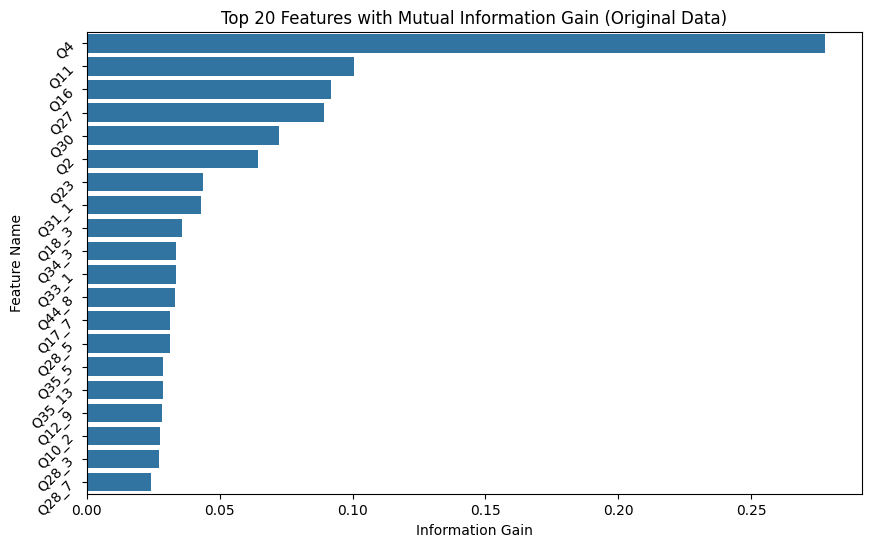

In [72]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

train_df_temp = train_df.drop(columns=['Country_Salary_Rank', 'Job_Salary_Rank'], errors='ignore')
test_df_temp = test_df.drop(columns=['Country_Salary_Rank', 'Job_Salary_Rank'], errors='ignore')
# Apply SelectKBest with mutual information regression to select features
fs = SelectKBest(score_func=mutual_info_regression, k='all')
fit = fs.fit(train_df_temp, y_train)

# Create DataFrame for feature importance
feature_imp = pd.DataFrame(fit.scores_, columns=['Score'], index=train_df_temp.columns)

# Select and plot the top 20 features
top_feature = feature_imp.nlargest(n= 20, columns=['Score'])

# Plotting
plt.figure(figsize=(10, 6))
g = sns.barplot(y=top_feature.index, x=top_feature['Score'])
plt.title('Top 20 Features with Mutual Information Gain (Original Data)')
plt.xlabel('Information Gain')
plt.ylabel('Feature Name')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [73]:
def add_selection_count_columns(df):
    # Identify multi-column groups based on common prefixes (e.g., 'Q6_', 'Q7_')
    columns = df.columns
    multi_column_groups = {}

    # Group columns by their common prefixes
    for col in columns:
        prefix = col.split('_')[0]
        if prefix != 'Q29':  # Skip Q29-related columns
            if prefix in multi_column_groups:
                multi_column_groups[prefix].append(col)
            else:
                multi_column_groups[prefix] = [col]

    # Create a count column for each group to store total selected options
    for group, cols in multi_column_groups.items():
        if len(cols) > 1:  # Only process groups with multiple columns
            count_column_name = f"{group}count" #_
            df[count_column_name] = df[cols].sum(axis=1)

    return df

In [74]:
train_df = add_selection_count_columns(train_df)
test_df = add_selection_count_columns(test_df)

In [75]:
train_df

,Q2,Q3,Q4,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,...,Q34count,Q35count,Q36count,Q37count,Q38count,Q39count,Q40count,Q41count,Q42count,Q44count
5955,27.0,0,2,0,0,0,0,0,0,0,...,1,4,1,1,1,0,1,0,0,3
6689,27.0,0,2,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
5897,37.0,0,3,0,0,0,0,0,0,0,...,0,2,0,1,1,0,1,0,0,5
7668,27.0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5002,27.0,0,5,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,27.0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
5390,32.0,0,2,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
860,42.0,0,4,1,1,1,1,1,1,0,...,2,6,2,1,1,0,1,0,2,3
7603,32.0,0,2,0,0,1,1,0,0,1,...,2,3,2,0,0,0,0,0,0,1


In [76]:
# Ensure 'Country_Salary_Rank' and 'Q11' columns exist in train_df and test_df.
# If they do not exist, create or map them as necessary.

# Create the new column in train_df
train_df['Country_Q11_Product'] = train_df['Country_Salary_Rank'] * train_df['Q11']

# Create the new column in test_df
test_df['Country_Q11_Product'] = test_df['Country_Salary_Rank'] * test_df['Q11']

# Display the first few rows of each DataFrame to verify the new column
print(train_df[['Country_Salary_Rank', 'Q11', 'Country_Q11_Product']].head())
print(test_df[['Country_Salary_Rank', 'Q11', 'Country_Q11_Product']].head())


      Country_Salary_Rank  Q11  Country_Q11_Product
5955                  4.0  4.0                 16.0
6689                  4.0  0.5                  2.0
5897                  5.0  7.5                 37.5
7668                  4.0  0.5                  2.0
5002                 10.0  2.0                 20.0
      Country_Salary_Rank   Q11  Country_Q11_Product
7918                  4.0   4.0                 16.0
5426                  2.0   4.0                  8.0
1430                  5.0  25.0                125.0
5325                  4.0   0.0                  0.0
7893                  8.0  25.0                200.0


## **Feature Selection**

- Select the features based on the criteria of your choice

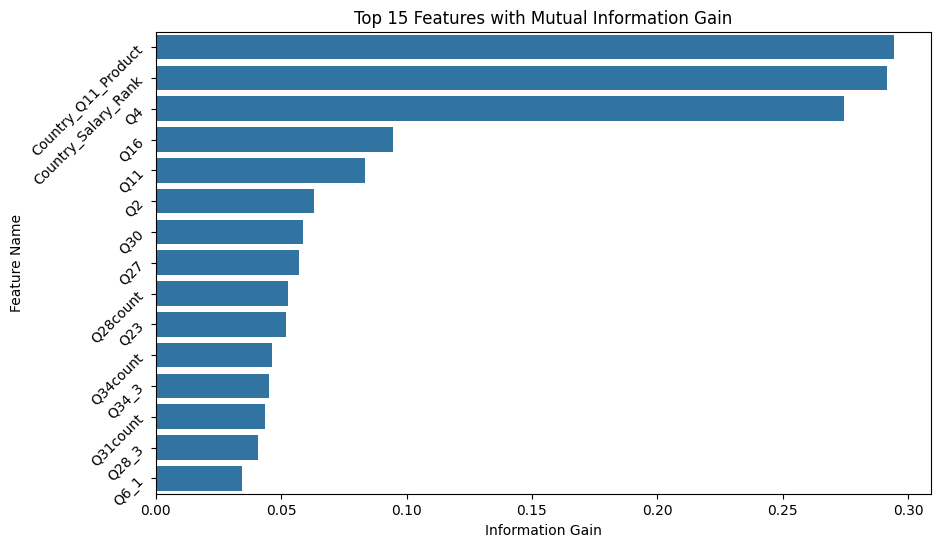

['Country_Q11_Product',
 'Country_Salary_Rank',
 'Q4',
 'Q16',
 'Q11',
 'Q2',
 'Q30',
 'Q27',
 'Q28count',
 'Q23',
 'Q34count',
 'Q34_3',
 'Q31count',
 'Q28_3',
 'Q6_1']

In [77]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Apply SelectKBest with mutual information regression to select features
fs = SelectKBest(score_func=mutual_info_regression, k='all')
fit = fs.fit(train_df, y_train)

# Create DataFrame for feature importance
feature_imp = pd.DataFrame(fit.scores_, columns=['Score'], index=train_df.columns)

# Select and plot the top 10 features
top_feature = feature_imp.nlargest(n= 15, columns=['Score'])

# Plotting
plt.figure(figsize=(10, 6))
g = sns.barplot(y=top_feature.index, x=top_feature['Score'])
plt.title('Top 15 Features with Mutual Information Gain')
plt.xlabel('Information Gain')
plt.ylabel('Feature Name')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')
plt.show()

# List of the top 10 features
top_features_list = top_feature.index.tolist()
top_features_list


In [78]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
train_df_selected = scaler.fit_transform(train_df[top_features_list])

# Convert the standardized array back to a DataFrame for easier handling
train_df_selected = pd.DataFrame(train_df_selected, columns=top_features_list)

# Display the first few rows of the standardized training data
train_df_selected.head()


,Country_Q11_Product,Country_Salary_Rank,Q4,Q16,Q11,Q2,Q30,Q27,Q28count,Q23,Q34count,Q34_3,Q31count,Q28_3,Q6_1
0,-0.457540,-0.420037,-0.445533,0.244544,-0.453922,-0.915860,-0.048557,0.874381,0.541729,-1.232642,0.323039,2.058086,0.151977,1.340423,-0.924478
1,-0.681594,-0.420037,-0.445533,-0.761728,-0.883300,-0.915860,-0.340542,1.439416,-0.808290,-0.146455,-0.693074,-0.485888,-0.751278,-0.746033,1.081692
2,-0.113457,-0.068674,0.191026,0.244544,-0.024543,-0.047817,-0.048557,0.874381,0.541729,-0.689548,-0.693074,-0.485888,0.151977,1.340423,-0.924478
3,-0.681594,-0.420037,-0.445533,-0.761728,-0.883300,-0.915860,-0.340542,-0.820725,-0.808290,0.939732,-0.693074,-0.485888,-0.751278,-0.746033,-0.924478
4,-0.393525,1.688137,1.464144,-0.761728,-0.699281,-0.915860,-0.311344,1.439416,-0.808290,-0.961095,-0.693074,-0.485888,-0.751278,-0.746033,-0.924478


## **Visualization**

- Make visualization to better understand your data

## **Apply the same feature engineering/selection to test data**

In [79]:
# Standardize the test set using the same scaler fitted on the training set
test_df_selected = scaler.transform(test_df[top_features_list])

# Convert the standardized array back to a DataFrame
test_df_selected = pd.DataFrame(test_df_selected, columns=top_features_list)

# Display the first few rows of the standardized test data
test_df_selected.head()


,Country_Q11_Product,Country_Salary_Rank,Q4,Q16,Q11,Q2,Q30,Q27,Q28count,Q23,Q34count,Q34_3,Q31count,Q28_3,Q6_1
0,-0.457540,-0.420037,-0.445533,-0.761728,-0.453922,-1.263077,-0.340542,-0.255690,-0.808290,0.125092,-0.693074,-0.485888,-0.751278,-0.746033,-0.924478
1,-0.585571,-1.122761,-1.718650,-0.330468,-0.453922,-0.915860,-0.311344,0.874381,-0.133280,-0.961095,0.323039,-0.485888,0.151977,-0.746033,-0.924478
2,1.286881,-0.068674,0.191026,3.550863,2.122347,1.688269,-0.340542,1.439416,0.541729,1.482825,-0.693074,-0.485888,-0.751278,1.340423,1.081692
3,-0.713602,-0.420037,-0.445533,-0.761728,-0.944639,-0.047817,-0.048557,0.874381,-0.133280,1.482825,-0.693074,-0.485888,-0.751278,-0.746033,1.081692
4,2.487171,0.985412,0.827585,-0.617974,2.122347,3.250747,-0.340542,-0.820725,-0.808290,0.396638,-0.693074,-0.485888,-0.751278,-0.746033,-0.924478


# Question 3: Model Implementation

## Implement Ordinal Logistic Regression Model

## Run k-fold cross validation

- Report the average/variance of accuracies across folds

In [80]:
import numpy as np
from sklearn.linear_model import LogisticRegression

class OrdinalLogisticRegression:
    def __init__(self, max_iter=100, penalty='l2', C=1.0, solver='lbfgs'):
        self.max_iter = max_iter
        self.penalty = penalty
        self.C = C
        self.solver = solver
        self.classes_ = []
        self.models_ = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        self.models_ = []

        for i, c in enumerate(self.classes_[:-1]):  # Train k-1 binary classifiers
            y_i = np.where(y <= c, 0, 1)

            model = LogisticRegression(max_iter=self.max_iter, penalty=self.penalty,
                                       C=self.C, solver=self.solver)
            model.fit(X, y_i)
            self.models_.append(model)

        return self

    def predict_proba(self, X):
        assert len(self.models_) > 0, "Model is not fitted yet. Run .fit() first."

        binary_probabilities = np.empty((X.shape[0], len(self.models_), 2), dtype=float)
        for i, model in enumerate(self.models_):
            binary_probabilities[:, i] = model.predict_proba(X)

        k = len(self.classes_)
        proba = np.empty((X.shape[0], k), dtype=float)
        proba[:, 0] = binary_probabilities[:, 0, 0]

        for i in range(1, k-1):
            proba[:, i] = binary_probabilities[:, i, 0] - binary_probabilities[:, i-1, 0]

        proba[:, -1] = binary_probabilities[:, k-2, 1]
        return proba


    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

    def get_params(self, deep=True):
        return {'max_iter': self.max_iter, 'penalty': self.penalty, 'C': self.C, 'solver': self.solver}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


In [81]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

# Reset indices of training data and target for alignment
train_df_selected = train_df_selected.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Set up k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []

# Initialize the Ordinal Logistic Regression model
model = OrdinalLogisticRegression(max_iter=100)

# Perform k-fold cross-validation
for train_index, val_index in kf.split(train_df_selected):
    # Select training and validation sets based on indices from KFold
    X_train, X_val = train_df_selected.iloc[train_index], train_df_selected.iloc[val_index]
    y_train_fold, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Fit the model on the training data
    model.fit(X_train, y_train_fold)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate standard accuracy without ±1 tolerance
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)

# Display average accuracy and variance
print("Average accuracy    : ", np.mean(accuracies))
print("Variance of accuracy: ", np.var(accuracies))


Average accuracy    :  0.39428193312064275
Variance of accuracy:  0.00017261204772492242


In [82]:
print(f"Here is the accuracy accross the 10 folds{accuracies}")

Here is the accuracy accross the 10 folds[0.38556067588325654, 0.4055299539170507, 0.42242703533026116, 0.38556067588325654, 0.39938556067588327, 0.3794162826420891, 0.3824884792626728, 0.40706605222734255, 0.38461538461538464, 0.39076923076923076]


In [83]:
print(min(accuracies))
print(max(accuracies))

0.3794162826420891
0.42242703533026116


## Bias-variance trade-off

[bias_variance_decomp.py](https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/bias_variance_decomp.py)

Below is a function you can use to compute the bias and variance of your ordinal logistic regression model. Using this function, analyze the ordinal logistic regression model performance based on bias-variance trade-off.

In [84]:
### NOTE: You don't need to change anything in this code block! ###

def _draw_bootstrap_sample(rng, X, y):
    sample_indices = np.arange(X.shape[0])
    bootstrap_indices = rng.choice(
        sample_indices, size=sample_indices.shape[0], replace=True
    )
    return X[bootstrap_indices], y[bootstrap_indices]

def bias_variance_decomp(
    estimator,
    X_train,
    y_train,
    X_test,
    y_test,
    num_rounds=10,
    random_seed=0
):
    """
    estimator : object
        A classifier or regressor object or class implementing both a
        `fit` and `predict` method similar to the scikit-learn API.

    X_train : array-like, shape=(num_examples, num_features)
        A training dataset for drawing the bootstrap samples to carry
        out the bias-variance decomposition.

    y_train : array-like, shape=(num_examples)
        Targets (class labels, continuous values in case of regression)
        associated with the `X_train` examples.

    X_test : array-like, shape=(num_examples, num_features)
        The test dataset for computing the average loss, bias,
        and variance.

    y_test : array-like, shape=(num_examples)
        Targets (class labels, continuous values in case of regression)
        associated with the `X_test` examples.

    num_rounds : int (default=10)
        Number of bootstrap rounds (sampling from the training set)
        for performing the bias-variance decomposition. Each bootstrap
        sample has the same size as the original training set.

    random_seed : int (default=0)
        Random seed for the bootstrap sampling used for the
        bias-variance decomposition.

    Returns
    ----------
    avg_bias, avg_var : returns the average bias, and average bias (all floats),
                        where the average is computed over the data points
                        in the test set.

    """
    loss = "mse"

    for ary in (X_train, y_train, X_test, y_test):
        assert type(ary) == np.ndarray, \
            "X_train, y_train, X_test, y_test have to be NumPy array. \
            If e.g., X_train is a pandas DataFrame, convert it to NumPy array \
            via X_train=X_train.values."

    rng = np.random.RandomState(random_seed)

    # All the predictions across different rounds
    all_pred = np.zeros((num_rounds, y_test.shape[0]), dtype=np.float64)

    for i in range(num_rounds):
        # Randomly sample training data
        X_boot, y_boot = _draw_bootstrap_sample(rng, X_train, y_train)

        # Fit the model using the randomly sampled data
        pred = estimator.fit(X_boot, y_boot).predict(X_test)
        all_pred[i] = pred

    # Mean prediction across runs using different dataset for each data point
    main_predictions = np.mean(all_pred, axis=0)

    # Average bias across different rounds
    avg_bias = np.sum((main_predictions - y_test) ** 2) / y_test.size

    # Average variance across different rounds
    avg_var = np.sum((main_predictions - all_pred) ** 2) / all_pred.size

    return avg_bias, avg_var

In [85]:
X_test = test_df_selected.to_numpy()
y_test = y_test.to_numpy()
X_train = train_df_selected.to_numpy()
y_train = y_train.to_numpy()

In [86]:
# Usage example
model = OrdinalLogisticRegression()
avg_bias, avg_var = \
    bias_variance_decomp(model, X_train, y_train, X_test, y_test, num_rounds=10, random_seed=0)

In [87]:
print(avg_bias, avg_var)

14.732070024570023 1.2521437346437347


In [88]:
# Initialize lists to store results
C_values = [0.0001, 0.001, 0.01, 0.1, 1 , 10 , 100]  # Range of C from 0.0001 to 100
avg_bias_list = []
avg_var_list = []
avg_accuracy_list = []

for C in C_values:
    # Initialize the Ordinal Logistic Regression model with varying C
    model = OrdinalLogisticRegression(max_iter=100, C=C)

    # Bias-Variance Decomposition
    avg_bias, avg_var = bias_variance_decomp(
        model, X_train, y_train, X_test, y_test, num_rounds=10, random_seed=0
    )

    # Perform k-fold cross-validation for accuracy
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []

    for train_index, val_index in kf.split(X_train):
        # Select training and validation sets based on indices from KFold
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Fit the model on the training data
        model.fit(X_train_fold, y_train_fold)

        # Make predictions on the validation data
        y_pred = model.predict(X_val_fold)

        # Calculate accuracy
        accuracy = accuracy_score(y_val_fold, y_pred)
        accuracies.append(accuracy)

    # Calculate average accuracy across folds
    avg_accuracy = np.mean(accuracies)
    avg_accuracy_list.append(avg_accuracy)

    # Store average bias and variance
    avg_bias_list.append(avg_bias)
    avg_var_list.append(avg_var)

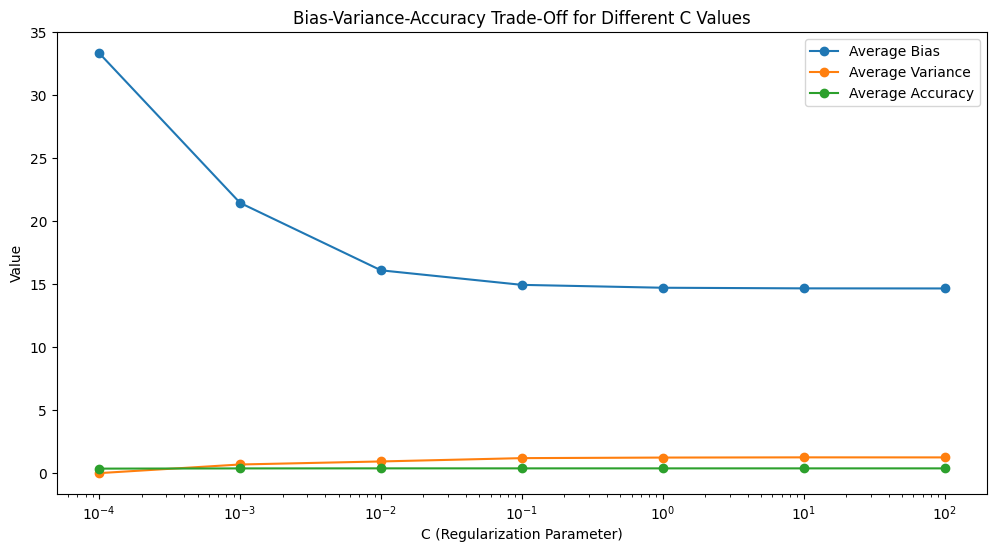

In [89]:
# Plotting bias, variance, and accuracy against C values
plt.figure(figsize=(12, 6))
plt.plot(C_values, avg_bias_list, label='Average Bias', marker='o')
plt.plot(C_values, avg_var_list, label='Average Variance', marker='o')
plt.plot(C_values, avg_accuracy_list, label='Average Accuracy', marker='o')
plt.xscale('log')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Value')
plt.title('Bias-Variance-Accuracy Trade-Off for Different C Values')
plt.legend()
plt.show()

Best C value: 0.01
Highest Accuracy: 0.3955112844145102


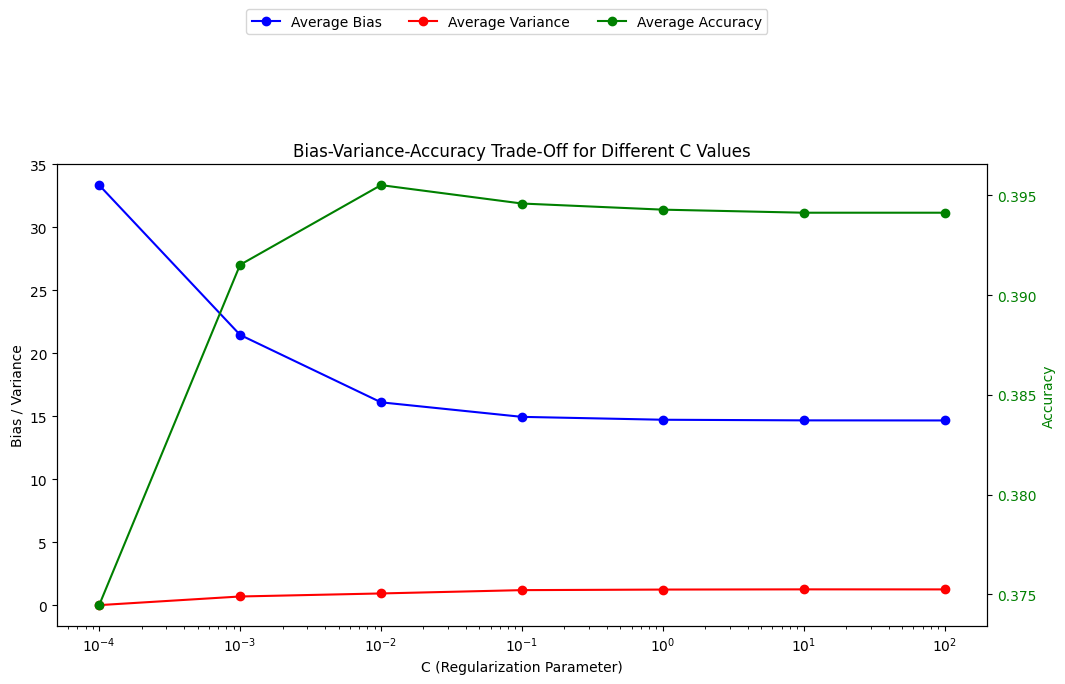

In [90]:
# Find the best C value with the highest accuracy
best_C = C_values[np.argmax(avg_accuracy_list)]
best_accuracy = max(avg_accuracy_list)

print(f"Best C value: {best_C}")
print(f"Highest Accuracy: {best_accuracy}")

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Bias and Variance on the first y-axis
ax1.plot(C_values, avg_bias_list, label='Average Bias', marker='o', color='blue')
ax1.plot(C_values, avg_var_list, label='Average Variance', marker='o', color='red')
ax1.set_xscale('log')
ax1.set_xlabel('C (Regularization Parameter)')
ax1.set_ylabel('Bias / Variance')
ax1.tick_params(axis='y')
ax1.set_title('Bias-Variance-Accuracy Trade-Off for Different C Values')

# Create a second y-axis for Accuracy
ax2 = ax1.twinx()
ax2.plot(C_values, avg_accuracy_list, label='Average Accuracy', marker='o', color='green')
ax2.set_ylabel('Accuracy', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3)

plt.show()


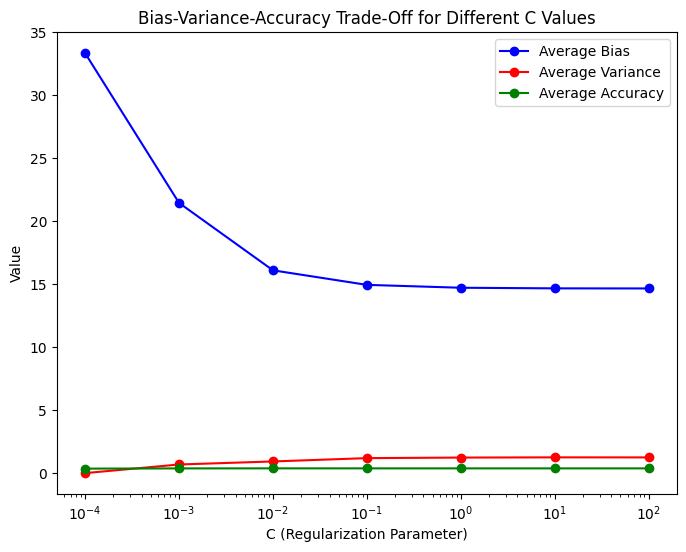

In [91]:
# Plotting bias, variance, and accuracy against C values (first plot)
plt.figure(figsize=(8, 6))
plt.plot(C_values, avg_bias_list, label='Average Bias', marker='o', color='blue')
plt.plot(C_values, avg_var_list, label='Average Variance', marker='o', color='red')
plt.plot(C_values, avg_accuracy_list, label='Average Accuracy', marker='o', color='green')
plt.xscale('log')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Value')
plt.title('Bias-Variance-Accuracy Trade-Off for Different C Values')
plt.legend()
plt.show()

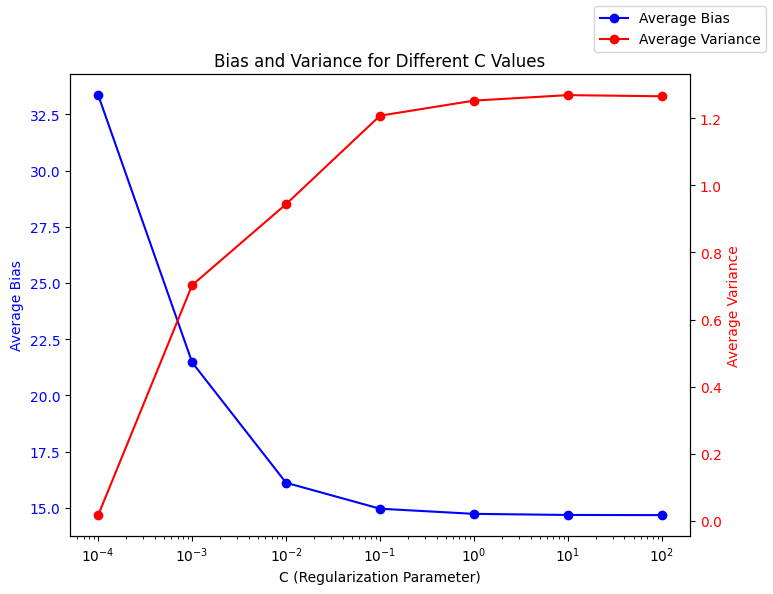

In [92]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot Bias on the first y-axis
ax1.plot(C_values, avg_bias_list, label='Average Bias', marker='o', color='blue')
ax1.set_xscale('log')
ax1.set_xlabel('C (Regularization Parameter)')
ax1.set_ylabel('Average Bias', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Bias and Variance for Different C Values')

# Create a second y-axis for Variance
ax2 = ax1.twinx()
ax2.plot(C_values, avg_var_list, label='Average Variance', marker='o', color='red')
ax2.set_ylabel('Average Variance', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
fig.legend()

plt.show()


In [93]:
#TODO: Discuss bias-variance trade-off of your ordinal logistic regression model

**Discussion**: The bias-variance trade-off in the ordinal logistic regression model is evident as we adjust the regularization parameter C. With very low C values (e.g., 10e-4
), the model exhibits high bias and low variance due to strong regularization, leading to underfitting. As C increases to around 0.01, bias significantly decreases while variance slightly increases, indicating a better fit to the data without excessive complexity.

At C = 0.01, the model achieves the highest accuracy (around 0.396), marking an optimal balance between bias and variance. Further increases in C don’t improve accuracy; the bias remains low, and variance stabilizes, suggesting the model has reached its ideal flexibility.

In summary, C = 0.01 is the best choice, balancing bias and variance for optimal accuracy. Lower C values cause underfitting, while higher values add unnecessary variance without performance gains.

# Question 4: Model Tuning

- What are the hyperparameters we can potentially set for our ordinal logistic regression model?
- Which hyperparameters seem to be worthwhile to tune?

## Grid Search

- Grid search will take time to complete - but if it does not finish in a few hours, you're probably trying too many combinations
- A recommended approach is to try a small number of combinations with a wide range first (for continuous value hyperparameters)! Then gradually increase the points that seem to be near optimal

In [94]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error

# Define custom scoring function using MAE for ordinal regression
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Define hyperparameter grid for tuning
param_grid = {
  #  'max_iter': [50, 100, 200],  # Higher iterations for potentially more complex convergence
    'penalty': ['l2', 'l1'],     # Testing regularization type: L1 (Lasso), L2 (Ridge)
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 50 , 100], # Wider range for regularization strength
   # 'solver': ['liblinear', 'lbfgs', 'sag'],  # Solvers compatible with 'l1' and 'l2' penalties
}

# Initialize the Ordinal Logistic Regression model
model = OrdinalLogisticRegression()

# Use GridSearchCV to find the best hyperparameters based on MAE
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=10,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search model
grid_search.fit(train_df_selected, y_train)

# Output the best hyperparameters and MAE score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (MAE):", grid_search.best_score_)


Fitting 10 folds for each of 14 candidates, totalling 140 fits
Best Parameters: {'C': 1.0, 'penalty': 'l2'}
Best Score (MAE): -2.5231778329197683


## Visualize the feature importance of your model

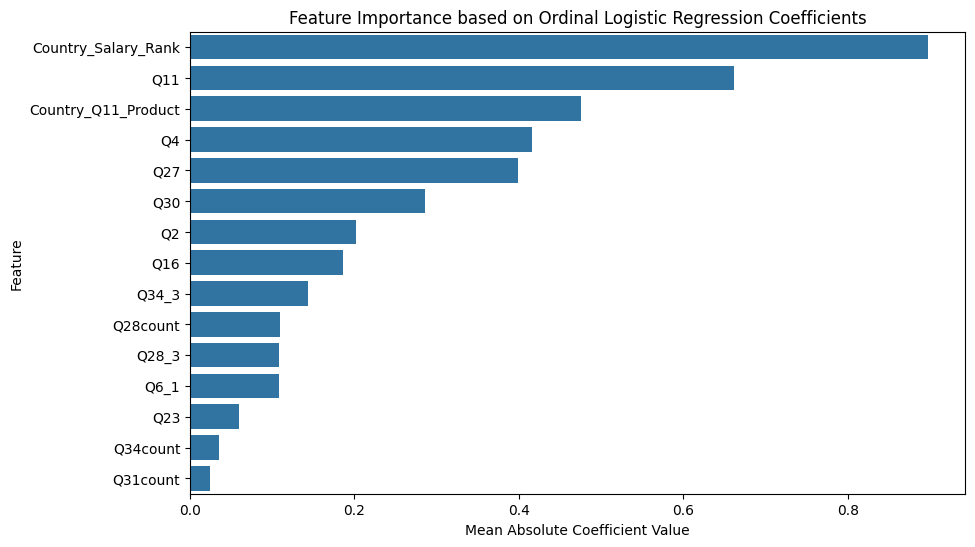

In [95]:
# Retrieve best parameters from grid search
best_params = grid_search.best_params_

# Initialize the Ordinal Logistic Regression model with the best hyperparameters
model = OrdinalLogisticRegression(
   # max_iter=best_params['max_iter'],
    penalty=best_params['penalty'],
    C=best_params['C'],
  #  solver=best_params['solver']
)

# Fit the model
model.fit(train_df_selected, y_train)

# Collect feature importance by taking the mean of the absolute coefficients across all binary models
feature_importances = np.mean([np.abs(m.coef_[0]) for m in model.models_], axis=0)

# Convert feature importances to a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({
    'Feature': train_df_selected.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(y=feature_importance_df['Feature'], x=feature_importance_df['Importance'])
plt.title('Feature Importance based on Ordinal Logistic Regression Coefficients')
plt.xlabel('Mean Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()


# Testing

Training accuracy: 0.39996926859250154
Testing accuracy: 0.4189189189189189


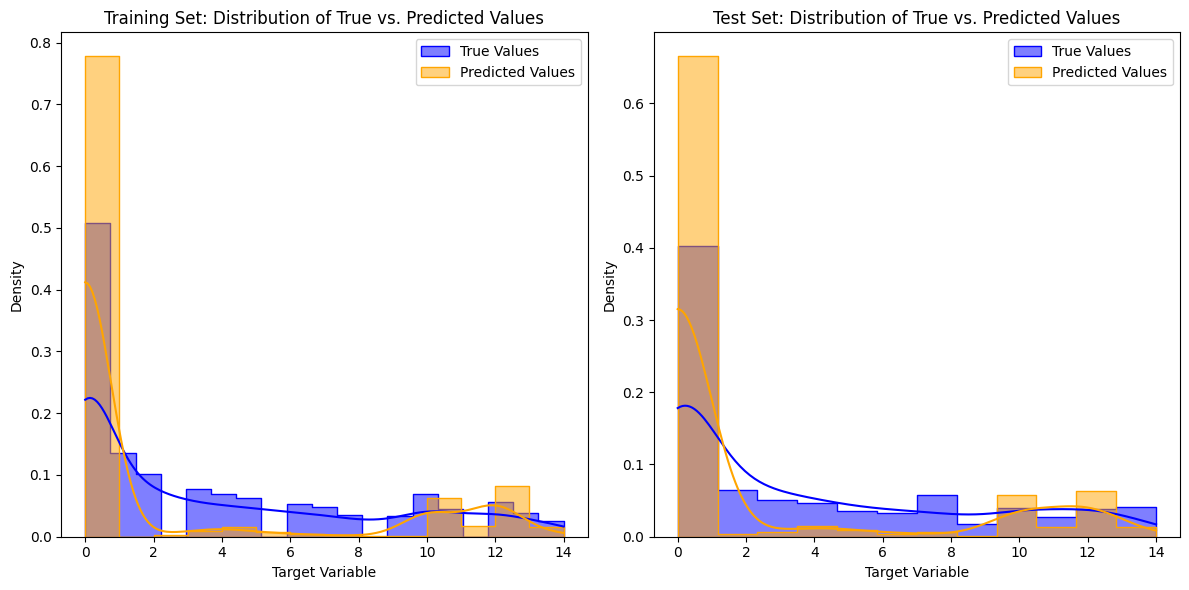

In [96]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Define the best-performing model with optimized hyperparameters
# Retrieve best parameters from grid search
best_params = grid_search.best_params_

# Initialize the Ordinal Logistic Regression model with the best hyperparameters
best_model = OrdinalLogisticRegression(
   # max_iter=best_params['max_iter'],
    penalty=best_params['penalty'],
    C=best_params['C'],
  #  solver=best_params['solver']
)


# Fit the model on the training data
best_model.fit(train_df_selected, y_train)

# Make predictions on both the training and test sets
y_train_pred = best_model.predict(train_df_selected)
y_test_pred = best_model.predict(test_df_selected)

# Calculate accuracy on training and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)

# Plot the distribution of true vs. predicted target values for training set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(y_train, color='blue', label='True Values', kde=True, stat="density", element="step")
sns.histplot(y_train_pred, color='orange', label='Predicted Values', kde=True, stat="density", element="step")
plt.title('Training Set: Distribution of True vs. Predicted Values')
plt.xlabel('Target Variable')
plt.legend()

# Plot the distribution of true vs. predicted target values for test set
plt.subplot(1, 2, 2)
sns.histplot(y_test, color='blue', label='True Values', kde=True, stat="density", element="step")
sns.histplot(y_test_pred, color='orange', label='Predicted Values', kde=True, stat="density", element="step")
plt.title('Test Set: Distribution of True vs. Predicted Values')
plt.xlabel('Target Variable')
plt.legend()

plt.tight_layout()
plt.show()
